In [3]:
from scipy import linalg
import ae352_quadrotor
from sympy import *
import numpy as np
from control import ctrb, acker, obsv, lqr
from scipy.signal import place_poles, StateSpace
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Define EOM
params = {
    'm': 0.4990514,
    'Jx': .0004635295,
    'Jy': .0006227343,
    'Jz': .007210787,
    'l': 0.1188466,
    'g': 9.81,
    'C_l/C_d' : 2
}

# components of position (meters)
p_x, p_y, p_z = symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = symbols('v_x, v_y, v_z')
v_in_body = Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = symbols('w_x, w_y, w_z')
w_in_body = Matrix([w_x, w_y, w_z])

tau_1, tau_2, tau_3, tau_4 = symbols('tau_1, tau_2, tau_3, tau_4')

# parameters
m = nsimplify(params['m'])
Jx = nsimplify(params['Jx'])
Jy = nsimplify(params['Jy'])
Jz = nsimplify(params['Jz'])
l = nsimplify(params['l'])
g = nsimplify(params['g'])
J = diag(Jx, Jy, Jz)
C = nsimplify(params['C_l/C_d'])

# rotation matrices
Rz = Matrix([[cos(psi), -sin(psi), 0], [sin(psi), cos(psi), 0], [0, 0, 1]])
Ry = Matrix([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = Matrix([[1], [0], [0]])
ey = Matrix([[0], [1], [0]])
ez = Matrix([[0], [0], [1]])
M = simplify(Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

v_dot = C/m*(tau_1+tau_2+tau_3+tau_4)*Matrix([[sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi)],[sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi)],[cos(theta)*cos(psi)]]) + R_body_in_world@Matrix([[0],[0],[-m*g]])

v_dot_real = Matrix([[g*sin(theta)-w_z*v_z+w_z*v_y],
                    [-g*cos(theta)*sin(phi)+w_x*v_z-w_z*v_x],
                    [-g*cos(phi)*cos(theta)-w_x*v_y+w_y*v_x+C/m*(tau_1+tau_2+tau_3+tau_4)]])

euler_dot = 1/cos(theta)*(Matrix([[0,sin(theta),cos(psi)],[0,cos(theta)*cos(psi),-cos(theta)*sin(psi)],[cos(theta),sin(theta)*sin(psi),sin(theta)*cos(psi)]])@Matrix([[w_x],[w_y],[w_z]]))
    
tau_phi = C*l*(tau_1-tau_3)
tau_theta = C*l*(tau_2-tau_4)
tau_psi = tau_1-tau_2+tau_3-tau_4

tau = Matrix([tau_phi,tau_theta,tau_psi])

tau = tau.T.T

w_in_body = w_in_body.T.T
    
alpha = J.inv() @ (tau-(w_in_body.cross(J@w_in_body)))

# equations of motion
f = Matrix.vstack(
    R_body_in_world@v_in_body,
    euler_dot,
    v_dot_real,
    alpha,
)

f = simplify(f, full=True)

# Position of drone in world frame
p_in_world = Matrix([p_x, p_y, p_z])

#linearizing system

w = Matrix([[p_x],
           [p_y],
           [p_z],
           [psi],
           [theta],
           [phi],
           [v_x],
           [v_y],
           [v_z],
           [w_x],
           [w_y],
           [w_z]])

p = Matrix([[tau_1],
           [tau_2],
           [tau_3],
           [tau_4]])

#Set w0 and p0
w0 = Matrix([[0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0],
           [0]])

p0 = Matrix([[.25*m**2*g/C],
           [.25*m**2*g/C],
           [.25*m**2*g/C],
           [.25*m**2*g/C]])

#Verify Equilibrium

'''print(f.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_1:p0[0],tau_2:p0[1],tau_3:p0[2],tau_4:p0[3]}))'''

#Solving for state-space form

A_sym = f.jacobian(w)
A = A_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_1:p0[0],tau_2:p0[1],tau_3:p0[2],tau_4:p0[3]})

B_sym = f.jacobian(p)
B = B_sym.subs({p_x:w0[0],p_y:w0[1],p_z:w0[2],psi:w0[3],theta:w0[4],phi:w0[5],v_x:w0[6],
        v_y:w0[7],v_z:w0[8],w_x:w0[9],w_y:w0[10],w_z:w0[11],tau_1:p0[0],tau_2:p0[1],tau_3:p0[2],tau_4:p0[3]})

#Check Whether W and O are Full rank. If W and O are full rank than the system is controllable and observable

A_num = np.array(A).astype(np.float64)
B_num = np.array(B).astype(np.float64)
w0_num = np.array(w0).astype(np.float64)

W = ctrb(A_num, B_num)

rank_W = np.linalg.matrix_rank(W)

num_states = A_num.shape[0]
is_full_rank_W = (rank_W == num_states)

print(is_full_rank_W)

#Design Observer and Controller for System with eigenvalues
#eig_K = np.array([-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12])
#eig_L = np.array([-100,-200,-300,-400,-500,-600,-700,-800,-900,-1000,-1100,-1200])

#Creating Q and R Matrices
Q = np.diag([10000, 10000, 10000, 1, 1, 1, 1000, 1000, 1000, 1, 1, 1])
R = np.diag([10, 10, 10, 10])

P = linalg.solve_continuous_are(A_num, B_num, Q, R)
K = linalg.inv(R) @ B_num.T @ P

True


In [4]:
# Define the initial conditions for the state and observer state
x0s = np.array([[0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0]])

x0 = x0s


# Combine the initial conditions
initial_conditions = np.hstack((x0.flatten()))

# Define the function for the state-space system
def test1(t, x):
    goal = Matrix([[0,0,1,0,0,0,0,0,0,0,0,0]])
    goal = np.array(goal).astype(np.float64)
    x_actual = (x - goal).T
    
    u = -K @ x_actual  # Control input
    
    # State-space dynamics
    dx_actual = A_num @ x_actual + B_num @ u
    
    return np.hstack((dx_actual.flatten()))

In [5]:
# Time span for integration
t_span = (0, 140)

# Integrate the system with the observer using solve_ivp
solution = solve_ivp(test1, t_span, initial_conditions, method='RK45', dense_output=False)

# Extract the state and observer state trajectories
x_actual_traj = solution.y[:A_num.shape[0], :]
x_actual_traj = np.around(x_actual_traj, decimals=4)

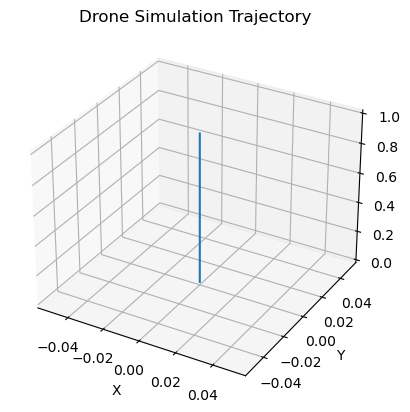

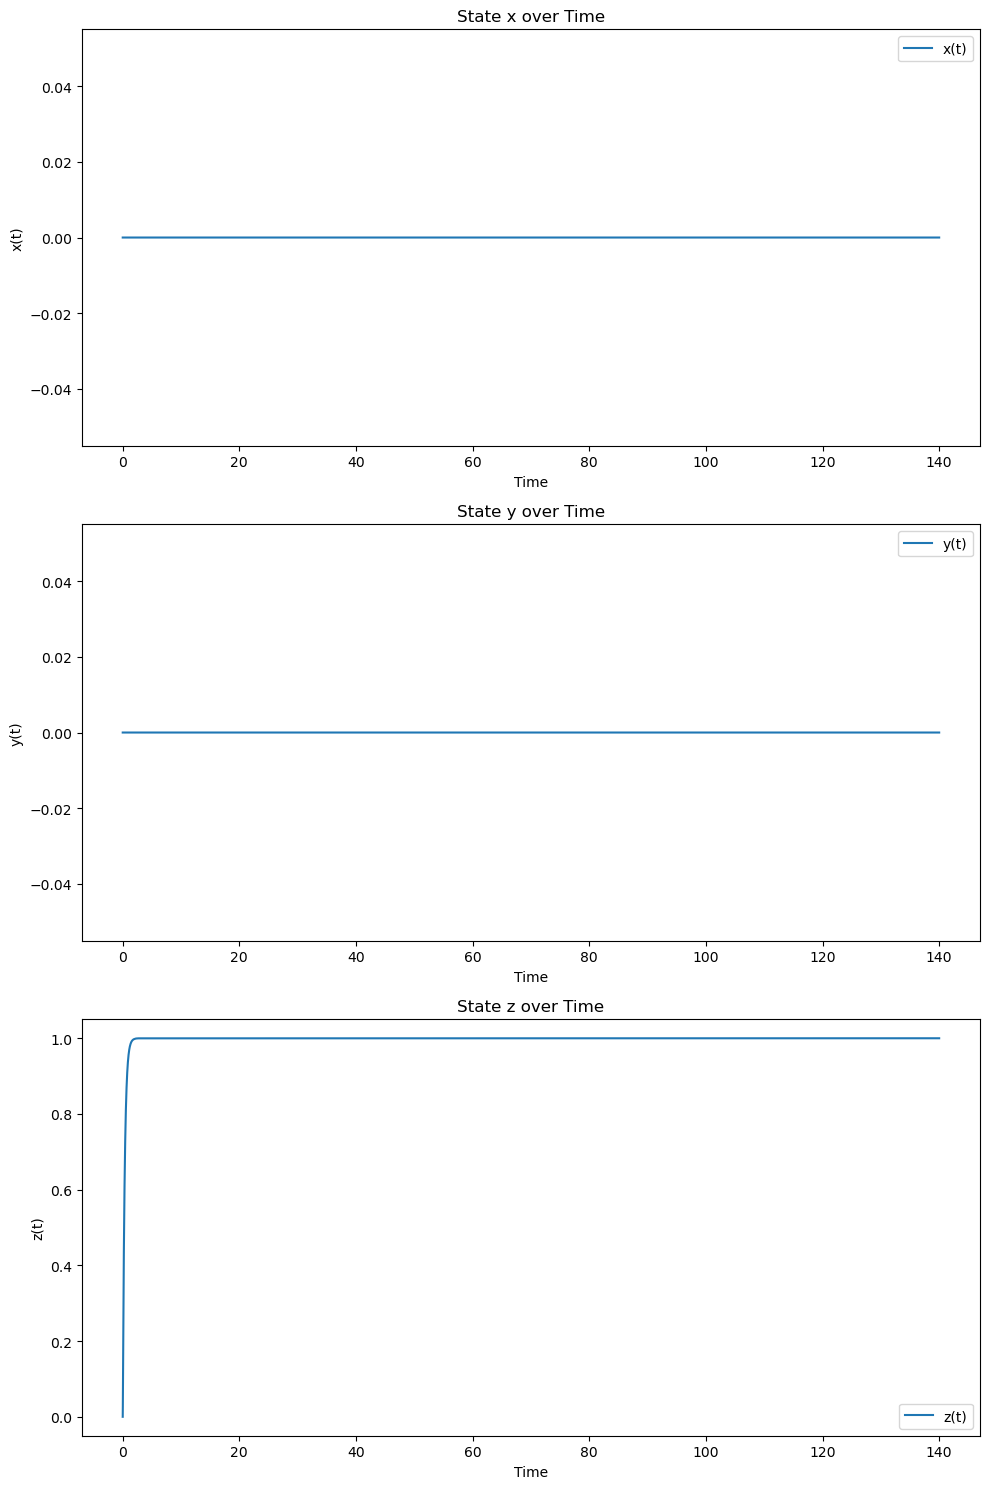

In [6]:
# to creating a 3d plot
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')
# Plot the results if needed
ax.plot3D(x_actual_traj[0], x_actual_traj[1], x_actual_traj[2])  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Drone Simulation Trajectory')
plt.show()

# Time values
time_values = solution.t

# Creating 3 subplots for the 2D plots
fig, axs = plt.subplots(3, figsize=(10, 15))

# Plot x vs. time
axs[0].plot(time_values, x_actual_traj[0], label='x(t)')
axs[0].set_title('State x over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x(t)')

# Plot y vs. time
axs[1].plot(time_values, x_actual_traj[1], label='y(t)')
axs[1].set_title('State y over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('y(t)')

# Plot z vs. time
axs[2].plot(time_values, x_actual_traj[2], label='z(t)')
axs[2].set_title('State z over Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z(t)')

# Displaying the legend for each subplot
for ax in axs:
    ax.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [7]:
# Define the initial conditions for the state and observer state
x0s = np.array([[2],
               [0],
               [1],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0]])

x0 = x0s


# Combine the initial conditions
initial_conditions = np.hstack((x0.flatten()))

# Define the function for the state-space system
def test2(t, x):
    omega = 0.125
    theta = omega*t
    goal = Matrix([[2*np.cos(theta),2*np.sin(theta),1,0,0,0,-0.25*np.sin(theta),0.25*np.cos(theta),0,0,0,0]])
    goal = np.array(goal).astype(np.float64)
    x_actual = (x - goal).T
    
    u = -K @ x_actual  # Control input
    
    # State-space dynamics
    dx_actual = A_num @ x_actual + B_num @ u
    
    return np.hstack((dx_actual.flatten()))

In [8]:
# Time span for integration
t_span = (0, 70)

# Integrate the system with the observer using solve_ivp
solution = solve_ivp(test2, t_span, initial_conditions, method='RK45', dense_output=False)

In [9]:
# Extract the state and observer state trajectories
x_actual_traj = solution.y[:A_num.shape[0], :]
x_actual_traj = np.around(x_actual_traj, decimals=4)
v = np.array([x_actual_traj[6],x_actual_traj[7],x_actual_traj[8]])
v_net = np.around(np.sqrt(np.sum(v**2, axis=0)), decimals=2)
v_net

array([0. , 0. , 0. , ..., 0.5, 0.5, 0.5])

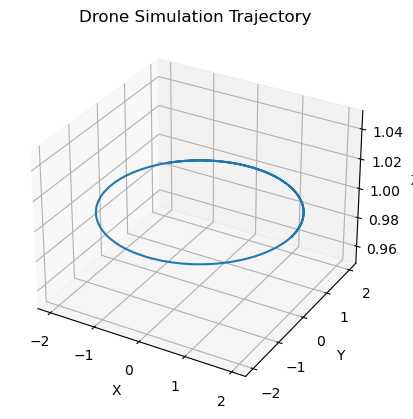

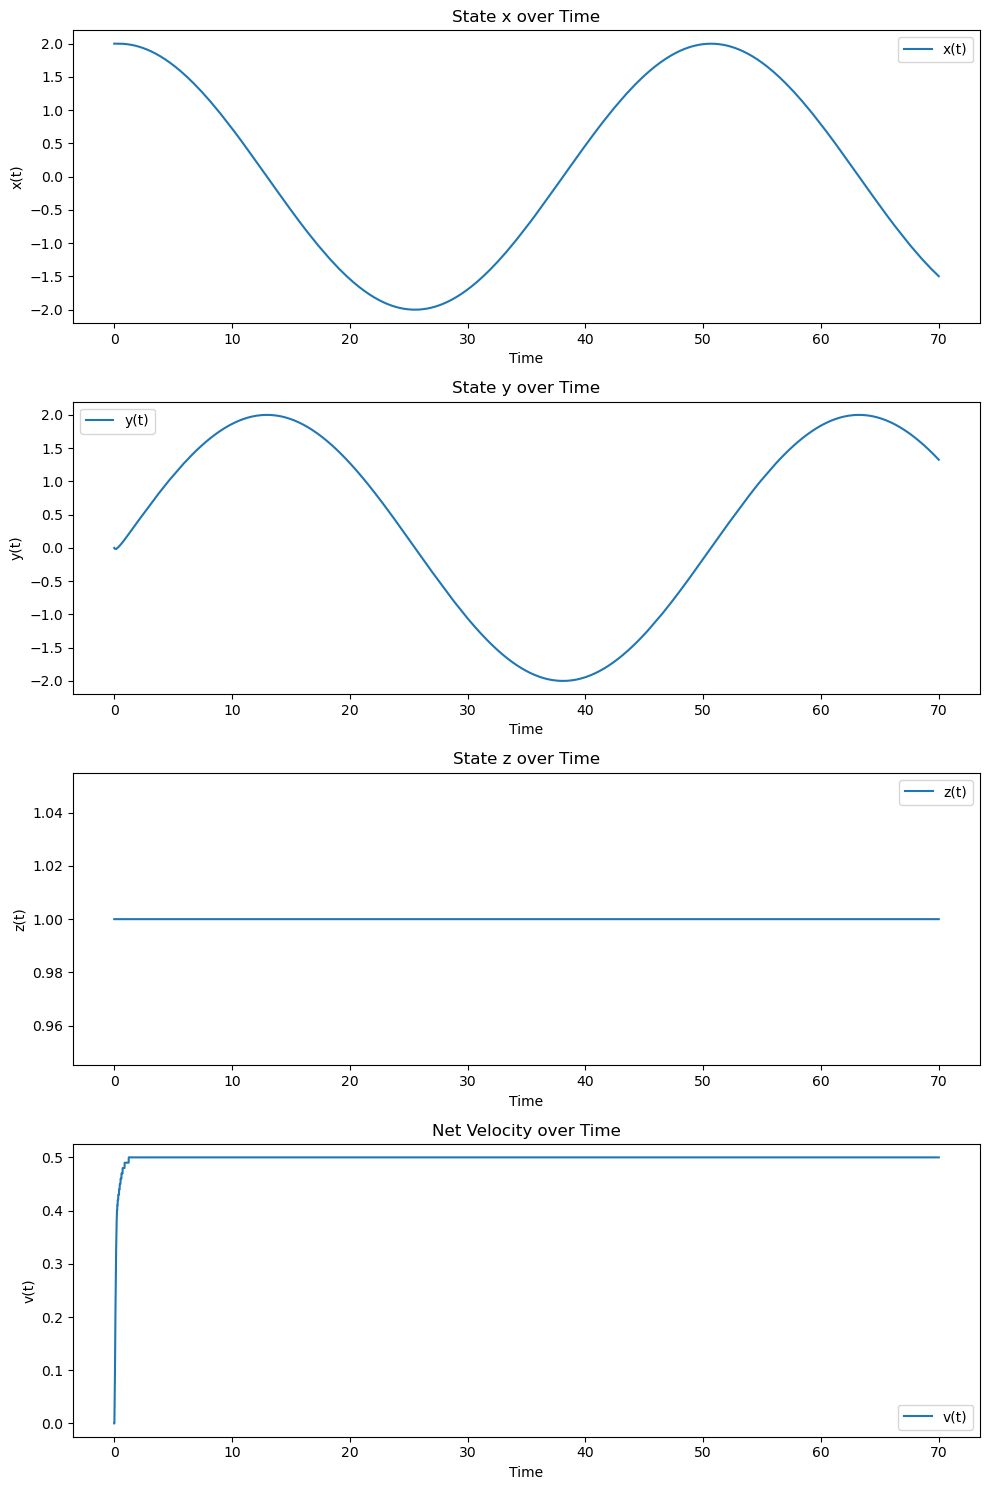

In [10]:
# to creating a 3d plot
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')
# Plot the results if needed
ax.plot3D(x_actual_traj[0], x_actual_traj[1], x_actual_traj[2])  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Drone Simulation Trajectory')
plt.show()

# Time values
time_values = solution.t

# Creating 3 subplots for the 2D plots
fig, axs = plt.subplots(4, figsize=(10, 15))

# Plot x vs. time
axs[0].plot(time_values, x_actual_traj[0], label='x(t)')
axs[0].set_title('State x over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x(t)')

# Plot y vs. time
axs[1].plot(time_values, x_actual_traj[1], label='y(t)')
axs[1].set_title('State y over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('y(t)')

# Plot z vs. time
axs[2].plot(time_values, x_actual_traj[2], label='z(t)')
axs[2].set_title('State z over Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z(t)')

# Plot v vs. time
axs[3].plot(time_values, v_net, label='v(t)')
axs[3].set_title('Net Velocity over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('v(t)')

# Displaying the legend for each subplot
for ax in axs:
    ax.legend()

# Display the plots
plt.tight_layout()
plt.show()



In [33]:
#Creating Q and R Matrices
Q = np.diag([10000, 10000, 10000, 10000, 1, 1, 1000, 1000, 1000, 1, 1, 1])
R = np.diag([1, 1, 1, 1])

P = linalg.solve_continuous_are(A_num, B_num, Q, R)
K = linalg.inv(R) @ B_num.T @ P

# Define the initial conditions for the state and observer state
x0s = np.array([[0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0],
               [0]])

x0 = x0s


# Combine the initial conditions
initial_conditions = np.hstack((x0.flatten()))

v1 = 1
v2 = .01
t1 = 0
t2 = 0
t3 = 0
t4 = 0
t5 = 0

# Define the function for the state-space system
def test3(t, x):
    
    global v1, v2, t1, t2, t3, t4, t5
    
    if np.around(x[2], decimals=1) < 1.0 and np.around(x[0], decimals=1) == 0.0 and np.around(x[1], decimals=1) == 0.0:
        goal = Matrix([[0,0,1,0,0,0,0,0,v1,0,0,0]])
        t1 = t
    elif t > t1 and t < t1 + 1:
        goal = Matrix([[0,0,1,0,0,0,0,0,0,0,0,0]])
    elif t > t1+1 and t < t1 + 6:
        goal = Matrix([[v1*(t-(t1+1)),0,1,0,0,0,0,0,0,0,0,0]])
        t2 = t
    elif t > t2 and t < t2 + 2:
        goal = Matrix([[5,0,1,0,0,0,0,0,0,0,0,0]])
        t3 = t
    elif t > t3 and t < t3 + 2:
        goal = Matrix([[5,0,1,-np.pi/2,0,0,0,0,0,0,0,0]])
        t4 = t
    elif t > t4 and t < t4 + 5:
        goal = Matrix([[5,v1*(t-t4),1,-np.pi/2,0,0,0,0,0,0,0,0]])
        t5 = t
    elif t > t4 + 5 and np.around(x[2], decimals=2) > 0.0:
        goal = Matrix([[5,5,1-v2*(t-t5),-np.pi/2,0,0,0,0,0,0,0,0]])
    else:
        goal = Matrix([[5,5,0,-np.pi/2,0,0,0,0,0,0,0,0]])
    
    goal = np.array(goal).astype(np.float64)
    x_actual = (x - goal).T
    
    u = -K @ x_actual  # Control input
    
    # State-space dynamics
    dx_actual = A_num @ x_actual + B_num @ u
    
    return np.hstack((dx_actual.flatten()))

In [40]:
# Time span for integration
t_span = (0, 120)

# Integrate the system with the observer using solve_ivp
solution = solve_ivp(test3, t_span, initial_conditions, method='RK45', dense_output=False)

# Extract the state and observer state trajectories
x_actual_traj = solution.y[:A_num.shape[0], :]
x_actual_traj = np.around(x_actual_traj, decimals=4)

In [41]:
import sys
np.set_printoptions(threshold=sys.maxsize)
v = np.array([x_actual_traj[6],x_actual_traj[7],x_actual_traj[8]])
v_net = np.around(np.sqrt(np.sum(v**2, axis=0)), decimals=2)

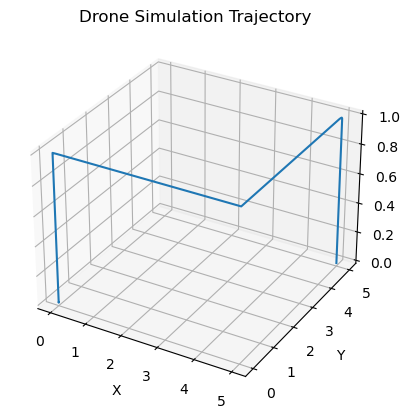

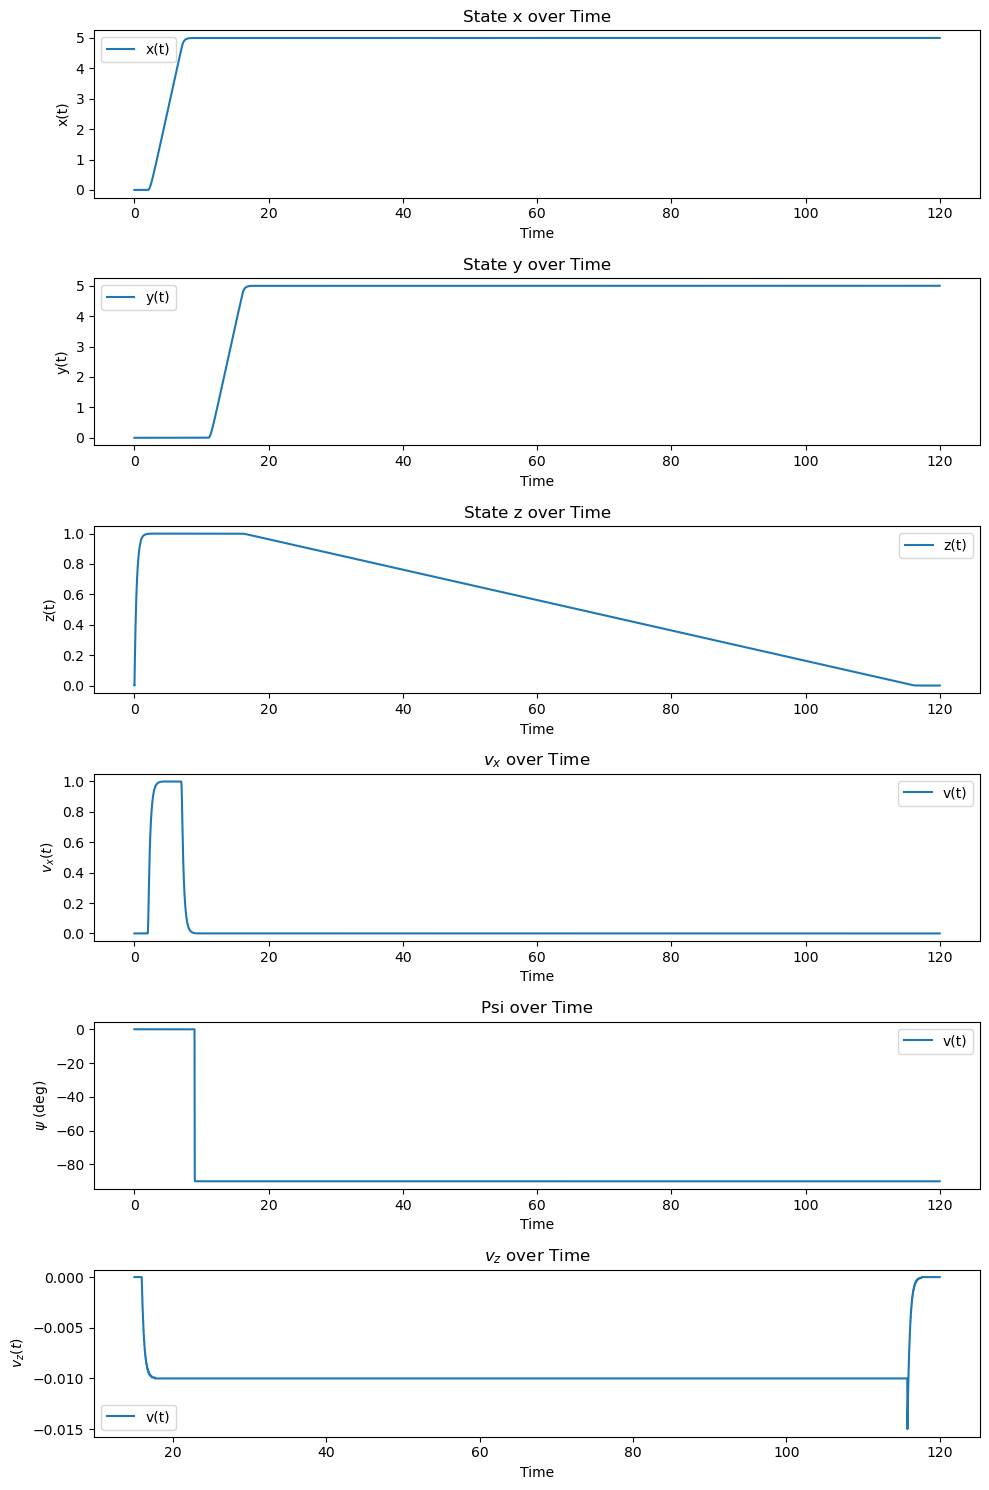

In [43]:
# to creating a 3d plot
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')
# Plot the results if needed
ax.plot3D(x_actual_traj[0], x_actual_traj[1], x_actual_traj[2])  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Drone Simulation Trajectory')
plt.show()

# Time values
time_values = solution.t

# Creating 3 subplots for the 2D plots
fig, axs = plt.subplots(6, figsize=(10, 15))

# Plot x vs. time
axs[0].plot(time_values, x_actual_traj[0], label='x(t)')
axs[0].set_title('State x over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x(t)')

# Plot y vs. time
axs[1].plot(time_values, x_actual_traj[1], label='y(t)')
axs[1].set_title('State y over Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('y(t)')

# Plot z vs. time
axs[2].plot(time_values, x_actual_traj[2], label='z(t)')
axs[2].set_title('State z over Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('z(t)')

# Plot v_x vs. time
axs[3].plot(time_values, x_actual_traj[6], label='v(t)')
axs[3].set_title('$v_x$ over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('$v_x(t)$')

#Plot yaw vs. time
axs[4].plot(time_values, x_actual_traj[3]/np.pi*180, label='v(t)')
axs[4].set_title('Psi over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('$\psi$ (deg)')

# Filter the time_values and corresponding v_z data for times greater than 15 seconds
time_filtered = time_values[time_values > 15]
vz_filtered = x_actual_traj[8][time_values > 15]

# Create the plot
axs[5].plot(time_filtered, vz_filtered, label='v(t)')
axs[5].set_title('$v_z$ over Time')
axs[5].set_xlabel('Time')
axs[5].set_ylabel('$v_z(t)$')


# Displaying the legend for each subplot
for ax in axs:
    ax.legend()

# Display the plots
plt.tight_layout()
plt.show()
